In [ ]:
#import the library
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import seaborn as sns
import logging
import os
os.chdir(r'E:\AAA_Labwork\Tcell tissues\v2')
import importlib
import warnings
warnings.filterwarnings("ignore")

import pickle as pkl
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
import ipympl
import matplotlib.collections as mcoll
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

class DraggableText:
    def __init__(self, text):
        self.text = text
        text.set_picker(True)  # enable pick events on the text
        self.press = None
        # connect pick event
        text.figure.canvas.mpl_connect('pick_event', self.on_pick)

    def on_pick(self, event):
        if event.artist is not self.text: return
        x0, y0 = self.text.get_position()
        xpress, ypress = event.mouseevent.xdata, event.mouseevent.ydata
        self.press = (x0, y0, xpress, ypress)
        # connect motion and release
        self.cidmotion = self.text.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)
        self.cidrelease = self.text.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)

    def on_motion(self, event):
        if self.press is None or event.xdata is None: return
        x0, y0, xpress, ypress = self.press
        dx, dy = event.xdata - xpress, event.ydata - ypress
        self.text.set_position((x0 + dx, y0 + dy))
        self.text.figure.canvas.draw_idle()

    def on_release(self, event):
        # disconnect the motion/release callbacks
        self.text.figure.canvas.mpl_disconnect(self.cidmotion)
        self.text.figure.canvas.mpl_disconnect(self.cidrelease)
        self.press = None

In [184]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = [12,6.5]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})

In [13]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [14]:
#This pallete is for colorblinds
my_palette = ['#0351A8','#8CB0E0','#D56D11','#FFBB78','#234E08',
              '#53CB8B','#D30083','#CB788D','#4E195A','#C58CCF',
              '#AA290F','#B03FD1','#E8BCCF','#64605F','#B2AD9A',
              '#D2D30B','#D1BD4F','#06DCF2','#9EDAE5','#517219',
              '#5B43CF','#D92F24','#FFD900','#002F33','#B8A3A3']
donor_palette = ["#be6535","#5437cb","#B2A97D"]
gut_palette = ['#0351A8','#8CB0E0','#D56D11','#FFBB78','#234E08',
              '#53CB8B','#D30083','#CB788D','#4E195A','#C58CCF',
              '#AA290F','#B03FD1','#E8BCCF','#64605F','#B2AD9A']

In [15]:
gut_immune_palette = [
    '#FFB27E',  # Monocytes
    '#FFCDD2',  # ILC1
    '#E57373',  # ILC3
    '#FF8C42',  # Macrophages
    '#9575CD',  # Memory B Cells
    '#E53935',  # NK
    '#D1C4E9',  # Naive B Cells
    '#512DA8',  # Plasma Cells
    '#388E3C',  # CD4 Treg
    '#81C784',  # CD4 Mobile TRM
    '#C8E6C9',  # CD4 TRM
    '#64B5F6',  # CD8 Mobile TRM
    '#1976D2',  # CD8aa MAIT
    '#0D47A1',  # CD8ab TRM
    '#B2DFDB',  # DN Mobile TRM
    '#20E5C1',  # TCRgd TRM
    '#CC6600'   # cDC2
]

In [16]:
gut_nonimmune_palette = [
    '#8DD3C7',
    '#FFFFB3',
    '#BEBADA',
    '#FB8072',
    '#80B1D3',
    '#FDB462',
    '#B3DE69',
    '#FCCDE5',
    '#D9D9D9',
    '#BC80BD',
    '#CCEBC5',
    '#FFED6F',
    '#1F78B4',
    '#33A02C',
    '#E31A1C',
    '#FF7F00'
]

In [17]:
adata = sc.read_h5ad(r"gut_annotated.h5ad")

In [158]:
adata.obs['Donor ID'] = adata.obs['batch']

In [159]:
# adata.obs['Donor ID'] = adata.obs['Donor ID'].map({'3':'Donor AJD3280','4':'Donor AJG2309','5':'Donor AJKQ118'})
adata.obs['Donor ID'] = adata.obs['Donor ID'].map({'3':'Donor 1','4':'Donor 2','5':'Donor 3'})

In [160]:
adata = adata[adata.obs['batch'].isin(['3','4'])]

In [161]:
adata.obs['celltype_highres'].values.categories

Index(['CD16- Conventional Monocytes', 'Colonocytes', 'Enteroendocrine Cells',
       'Fibroblast', 'Fibroblastic Reticular Cells', 'Goblet Cells', 'ILC1',
       'ILC3', 'Intestinal Stem Cells', 'Lymphatic Endothelial Cells',
       'M2-like CD16+ Macrophages', 'MAdCAM1+ Endothelial Cells',
       'MAdCAM1- Endothelial Cells', 'Memory B Cells', 'Telocytes',
       'Muscularis Smooth Muscle Cells', 'NK', 'Naive B Cells',
       'Enteric Glial Cells', 'Plasma Cells', 'SPIB+ Cells',
       'TCRab CD4 FOXP3+ Treg', 'TCRab CD4 Mobile TRM', 'TCRab CD4 TRM',
       'TCRab CD8 Mobile TRM', 'TCRab CD8 TRM', 'TCRab CD8aa MAIT',
       'TCRab CD8ab TRM', 'TCRab DN Mobile TRM', 'TCRgd TRM',
       'Transit Amplifying Cells', 'Tuft Cells',
       'Vascular Smooth Muscle Cells', 'cDC2'],
      dtype='object')

In [162]:
adata.obs['celltype_lowres'] = adata.obs['celltype_lowres'].astype('category')
ordered_celltype=['T Cells','NK','ILC','B Cells', 'Plasma Cells',
                  'Monocytes','Macrophages','Dendritic Cells', 
                  'Endothelial Cells', 'Telocytes','Fibroblastic Reticular Cells','Fibroblast','Smooth Muscle Cells',
                  'Intestinal Epithelial Cells','Enteric Glial Cells']
adata.obs['celltype_lowres'] = adata.obs['celltype_lowres'].cat.reorder_categories(ordered_celltype)

In [163]:
adata_immune = adata[adata.obs['celltype_lowres'].isin(['T Cells','NK','ILC','B Cells', 'Plasma Cells',
                  'Monocytes','Macrophages','Dendritic Cells'])]
adata_nonimmune = adata[~adata.obs['celltype_lowres'].isin(['T Cells','NK','ILC','B Cells', 'Plasma Cells',
                  'Monocytes','Macrophages','Dendritic Cells'])]

In [164]:
adata_immune.obs['celltype_highres']=adata_immune.obs['celltype_highres'].replace({'TCRab CD8 TRM':'TCRab CD8ab TRM',
                                                                                   'TCRab CD8 Mobile TRM':'TCRab CD8ab Mobile TRM'})

In [165]:
adata_nonimmune.obs['celltype_highres'].values.categories

Index(['Colonocytes', 'Enteroendocrine Cells', 'Fibroblast',
       'Fibroblastic Reticular Cells', 'Goblet Cells', 'Intestinal Stem Cells',
       'Lymphatic Endothelial Cells', 'MAdCAM1+ Endothelial Cells',
       'MAdCAM1- Endothelial Cells', 'Telocytes',
       'Muscularis Smooth Muscle Cells', 'Enteric Glial Cells', 'SPIB+ Cells',
       'Transit Amplifying Cells', 'Tuft Cells',
       'Vascular Smooth Muscle Cells'],
      dtype='object')

In [166]:
adata_immune.obs['celltype_highres'].values.categories

Index(['CD16- Conventional Monocytes', 'ILC1', 'ILC3',
       'M2-like CD16+ Macrophages', 'Memory B Cells', 'NK', 'Naive B Cells',
       'Plasma Cells', 'TCRab CD4 FOXP3+ Treg', 'TCRab CD4 Mobile TRM',
       'TCRab CD4 TRM', 'TCRab CD8ab Mobile TRM', 'TCRab CD8aa MAIT',
       'TCRab CD8ab TRM', 'TCRab DN Mobile TRM', 'TCRgd TRM', 'cDC2'],
      dtype='object')

In [167]:
adata.obs['celltype_lowres'] = adata.obs['celltype_lowres'].astype('category')
ordered_celltype=['T Cells','NK','ILC','B Cells', 'Plasma Cells',
                  'Monocytes','Macrophages','Dendritic Cells', 
                  'Endothelial Cells', 'Telocytes','Fibroblastic Reticular Cells','Fibroblast','Smooth Muscle Cells',
                  'Intestinal Epithelial Cells','Enteric Glial Cells']
adata.obs['celltype_lowres'] = adata.obs['celltype_lowres'].cat.reorder_categories(ordered_celltype)

In [168]:
A = adata_immune.X
coo = A.tocoo()
mask = np.isinf(coo.data)
inf_coords = list(zip(coo.row[mask], coo.col[mask]))
print("infinite at:", inf_coords)

infinite at: []


In [169]:
sc.pp.filter_genes(adata_immune, min_counts=1)
sc.pp.highly_variable_genes(adata_immune, flavor='seurat_v3', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_immune.var['highly_variable'])))
sc.pp.pca(adata_immune, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_immune, n_neighbors = 15, n_pcs = 50)
sc.tl.umap(adata_immune, min_dist = 2, spread = 1.5)


 Number of highly variable genes: 2000


In [170]:
replace_map ={
    'CD16- Conventional Monocytes': 'CD16- mono',
    'ILC1': 'ILC1',
    'ILC3': 'ILC3',
    'M2-like CD16+ Macrophages': 'M2-like mac',
    'Memory B Cells': 'Memory B',
    'NK': 'NK',
    'Naive B Cells': 'Naive B',
    'Plasma Cells': 'Plasma',
    'TCRab CD4 FOXP3+ Treg': 'CD4 Treg',
    'TCRab CD4 Mobile TRM': 'CD4 Mob TRM',
    'TCRab CD4 TRM': 'CD4 TRM',
    'TCRab CD8ab Mobile TRM': 'CD8 Mob TRM',
    'TCRab CD8aa MAIT': 'CD8aa MAIT',
    'TCRab CD8ab TRM': 'CD8ab TRM',
    'TCRab DN Mobile TRM': 'DN Mob TRM',
    'TCRgd TRM': 'gd TRM',
    'cDC2': 'cDC2'
}

adata_immune.obs['celltype_highres_short'] = adata_immune.obs['celltype_highres']
adata_immune.obs['celltype_highres_short'] = adata_immune.obs['celltype_highres_short'].replace(replace_map)

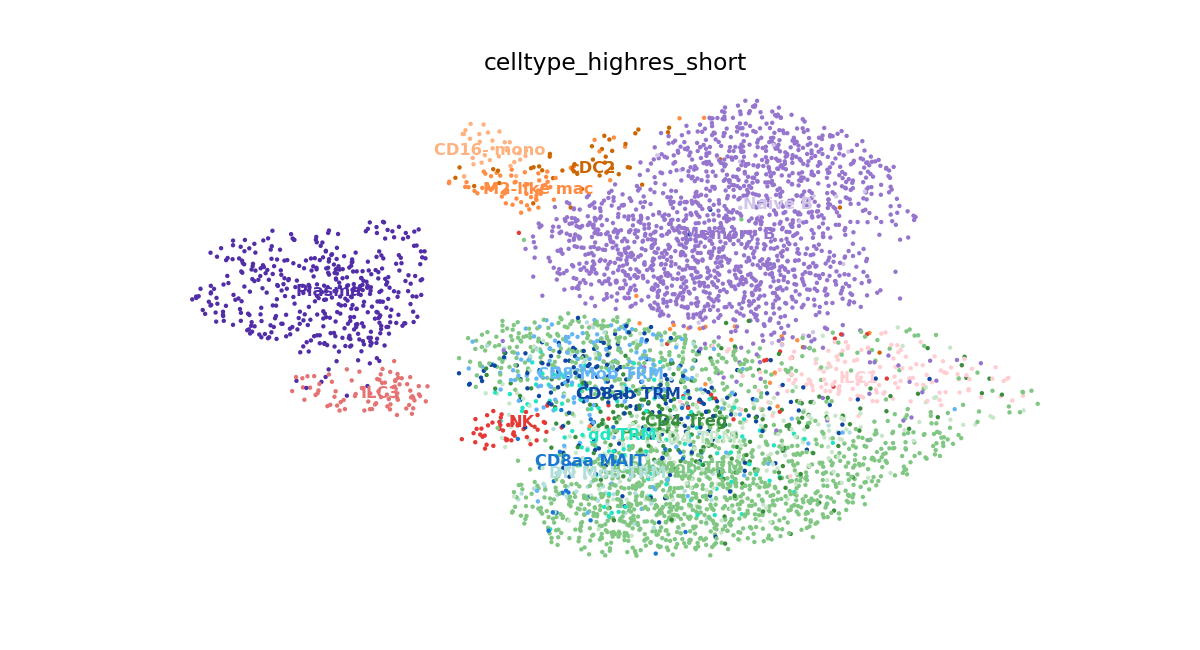

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [ ]:
%matplotlib widget

fig = sc.pl.umap(
    adata_immune,
    color='celltype_highres_short',
    size=40, 
    ncols=1,
    palette=gut_immune_palette,
    return_fig=True,
    legend_fontsize='small',
    legend_loc='on data',
    frameon=False
)

axes = fig.get_axes()
for ax in axes:
    # grab the scatter PathCollections
    scatter_objs = [
        coll for coll in ax.collections
        if isinstance(coll, mcoll.PathCollection)
    ]
    # grab all the Text labels
    texts = ax.texts
    
    for i, txt in enumerate(texts):
        label = txt.get_text()                       # e.g. 'CD16- mono'
        facecolor = gut_immune_palette[i]        # grab the correct HEX
        txt.set_color(facecolor)                     # set the text fill
        # txt.set_fontsize(20)
        # if label not in ['Plasma','CD8ab TRM','CD8aa MAIT','Memory B','CD4 Treg']:
        #     txt.set_path_effects([                       # add a black outline
        #         PathEffects.withStroke(linewidth=2, foreground='black')
        #     ])
    draggables = [DraggableText(txt) for txt in texts]
    #     adjust_text(
#         texts,
#         ax=ax,
#         avoid_objects=scatter_objs,    # ← use this kwarg
#         expand_points=(3, 3),          # ← inflate point bboxes by 3×
#         expand_objects=(1.2, 1.2),     # ← optional, inflate artist bboxes
#         arrowprops=dict(arrowstyle='->', color='gray'),
#         only_move={'points':'y','text':'xy'},
#         force_text=(0.1, 0.25),
#         force_points=(0.1, 0.25),
#         save_steps=False
#     )


In [188]:
sc.pp.filter_genes(adata_nonimmune, min_counts=1)
sc.pp.highly_variable_genes(adata_nonimmune, flavor='seurat_v3', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_nonimmune.var['highly_variable'])))
sc.pp.pca(adata_nonimmune, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_nonimmune, n_neighbors = 15, n_pcs = 50)
sc.tl.umap(adata_nonimmune, min_dist = 2, spread = 1.5)


 Number of highly variable genes: 2000


In [190]:
celltype_shortnames = {
    'Colonocytes': 'Colonocyte',
    'Enteroendocrine Cells': 'EEC',
    'Fibroblast': 'Fibroblast',
    'Fibroblastic Reticular Cells': 'FRC',
    'Goblet Cells': 'Goblet',
    'Intestinal Stem Cells': 'ISC',
    'Lymphatic Endothelial Cells': 'LEC',
    'MAdCAM1+ Endothelial Cells': 'MAdCAM1+ EC',
    'MAdCAM1- Endothelial Cells': 'MAdCAM1- EC',
    'Telocytes': 'Telocyte',
    'Muscularis Smooth Muscle Cells': 'mSMC',
    'Enteric Glial Cells': 'EGC',
    'SPIB+ Cells': 'SPIB+',
    'Transit Amplifying Cells': 'TA',
    'Tuft Cells': 'Tuft',
    'Vascular Smooth Muscle Cells': 'vSMC'
}


adata_nonimmune.obs['celltype_highres_short'] = adata_nonimmune.obs['celltype_highres']
adata_nonimmune.obs['celltype_highres_short'] = adata_nonimmune.obs['celltype_highres_short'].replace(celltype_shortnames)

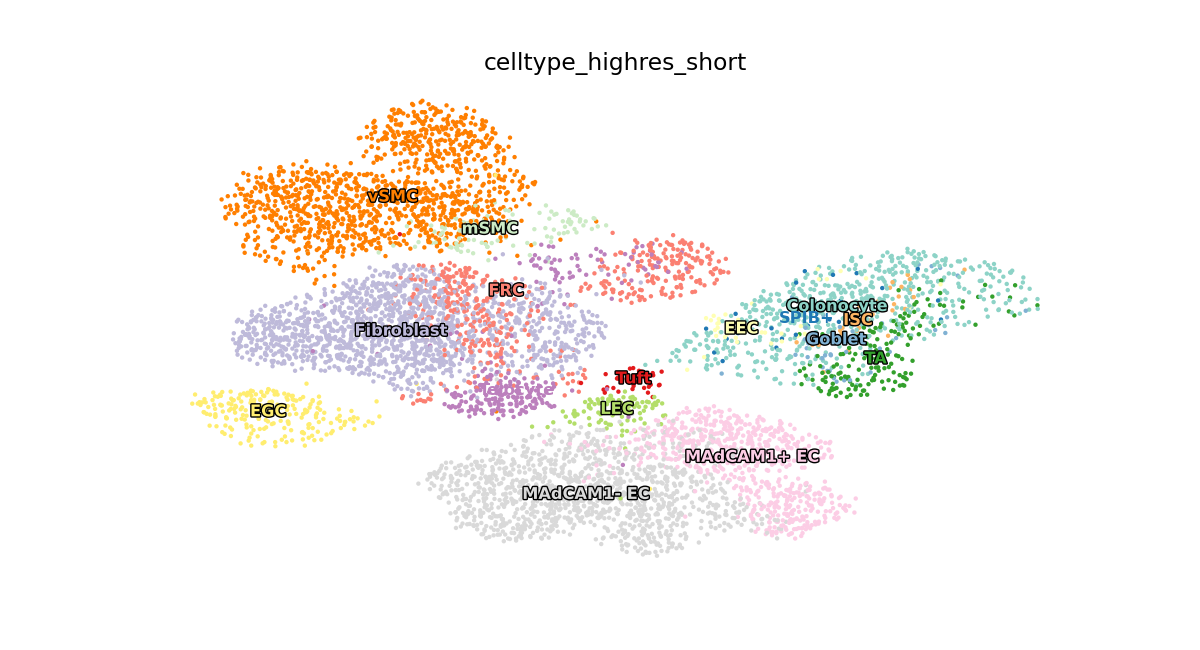

In [192]:
%matplotlib notebook
import ipympl
import matplotlib.collections as mcoll
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

fig = sc.pl.umap(
    adata_nonimmune,
    color='celltype_highres_short',
    size=40, 
    ncols=1,
    palette=gut_nonimmune_palette,
    return_fig=True,
    legend_fontsize='small',
    legend_loc='on data',
    frameon=False
)

axes = fig.get_axes()
for ax in axes:
    texts = ax.texts
    
    for i, txt in enumerate(texts):
        label = txt.get_text()                       # e.g. 'CD16- mono'
        facecolor = gut_nonimmune_palette[i]        # grab the correct HEX
        txt.set_color(facecolor)                     # set the text fill
        if label not in ['SPIB+','Telocyte']:
            txt.set_path_effects([                       # add a black outline
                PathEffects.withStroke(linewidth=2, foreground='black')
            ])
    draggables = [DraggableText(txt) for txt in texts]
    #     adjust_text(
#         texts,
#         ax=ax,
#         avoid_objects=scatter_objs,    # ← use this kwarg
#         expand_points=(3, 3),          # ← inflate point bboxes by 3×
#         expand_objects=(1.2, 1.2),     # ← optional, inflate artist bboxes
#         arrowprops=dict(arrowstyle='->', color='gray'),
#         only_move={'points':'y','text':'xy'},
#         force_text=(0.1, 0.25),
#         force_points=(0.1, 0.25),
#         save_steps=False
#     )


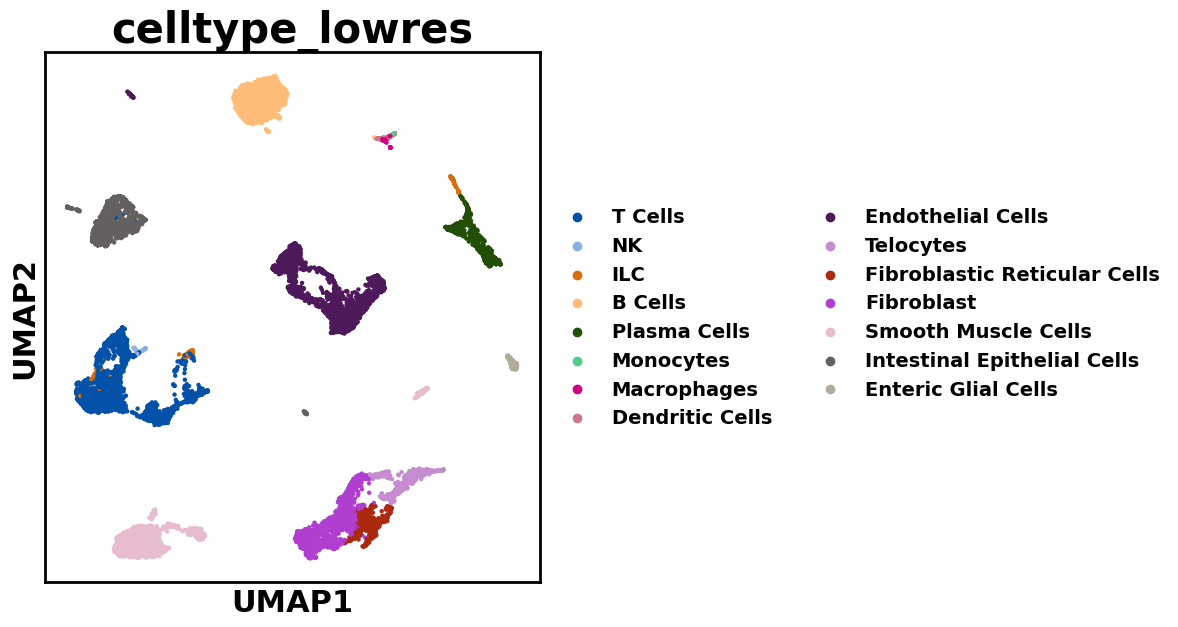

In [36]:
# plt.rcParams['axes.linewidth'] = 2
# plt.rcParams['figure.figsize'] = [12,6.5]
# plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})

# plt.close()
# fig = sc.pl.umap(adata, color = ['celltype_lowres'],
#                  size = 40, ncols = 1,palette = gut_palette,
#                  return_fig = True, legend_fontsize = 'medium')
# ax = fig.get_axes()
# for i in range(0,len(ax)):
#     ax[i].xaxis.label.set_fontsize(22)
#     ax[i].xaxis.label.set_fontweight('bold')
#     ax[i].yaxis.label.set_fontsize(22)
#     ax[i].title.set_fontsize(30)
#     ax[i].yaxis.label.set_fontweight('bold')
#     ax[i].title.set_fontweight('bold')

# plt.tight_layout()
# plt.savefig('vis/gut_celltype_low_umap.png',dpi = 300,bbox_inches='tight')

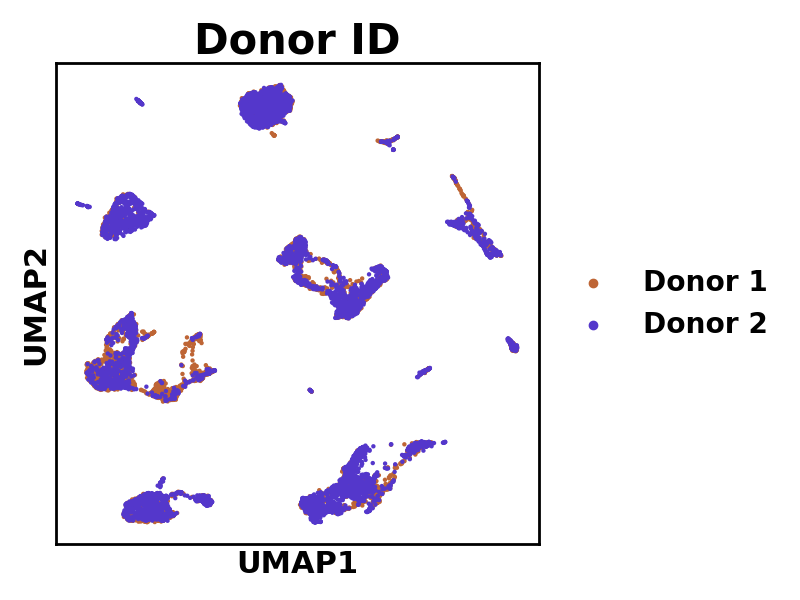

In [36]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = [8,6]

plt.close()
fig = sc.pl.umap(adata, color = ['Donor ID'],
                 size = 40, ncols = 1,palette = donor_palette,
                 return_fig = True, legend_fontsize = 'x-large')
ax = fig.get_axes()
for i in range(0,len(ax)):
    ax[i].xaxis.label.set_fontsize(22)
    ax[i].xaxis.label.set_fontweight('bold')
    ax[i].yaxis.label.set_fontsize(22)
    ax[i].title.set_fontsize(30)
    ax[i].yaxis.label.set_fontweight('bold')
    ax[i].title.set_fontweight('bold')

plt.tight_layout()
plt.savefig('vis/gut_donor_umap.png',dpi = 300,bbox_inches='tight')

In [89]:
nonimmune_donor_df = adata_nonimmune.obs.groupby('Donor ID')['celltype_highres_short'].value_counts().unstack(fill_value=0)
nonimmune_donor_df= nonimmune_donor_df.div(nonimmune_donor_df.sum(axis = 0),axis = 1)

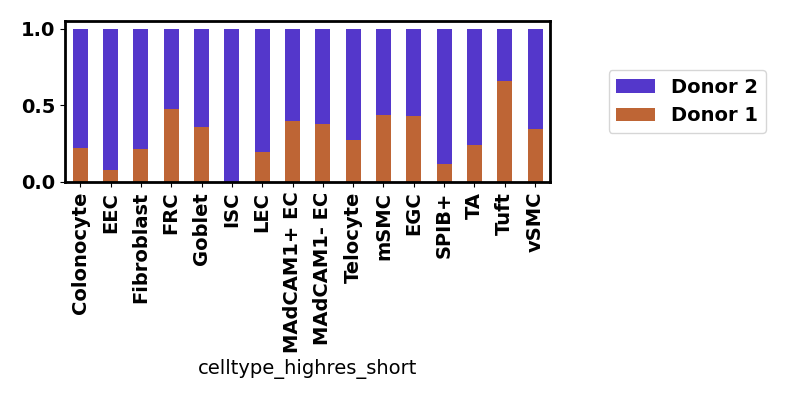

In [94]:
plt.rcParams['figure.figsize'] = [8,4]
nonimmune_donor_df.transpose().plot.bar(stacked = True, color = donor_palette[0:2]).legend(loc='center left',bbox_to_anchor=(1.1, 0.5),reverse= True)
plt.tight_layout()
plt.savefig('vis/gut_nonimmune_donor_contribution.png',dpi = 300,bbox_inches='tight')

In [95]:
immune_donor_df = adata_immune.obs.groupby('Donor ID')['celltype_highres_short'].value_counts().unstack(fill_value=0)
immune_donor_df= immune_donor_df.div(immune_donor_df.sum(axis = 0),axis = 1)

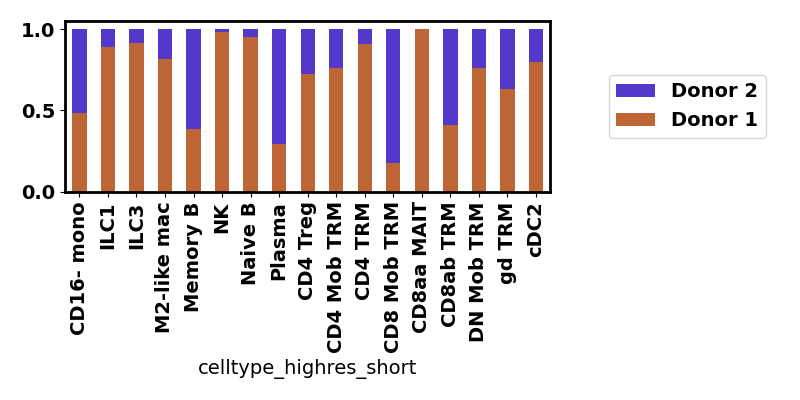

In [96]:
plt.rcParams['figure.figsize'] = [8,4]
immune_donor_df.transpose().plot.bar(stacked = True, color = donor_palette[0:2]).legend(loc='center left',bbox_to_anchor=(1.1, 0.5),reverse= True)
plt.tight_layout()
plt.savefig('vis/gut_immune_donor_contribution.png',dpi = 300,bbox_inches='tight')

In [ ]:
adata3 = adata[adata.obs['batch']=='3']
adata4 = adata[adata.obs['batch']=='4']

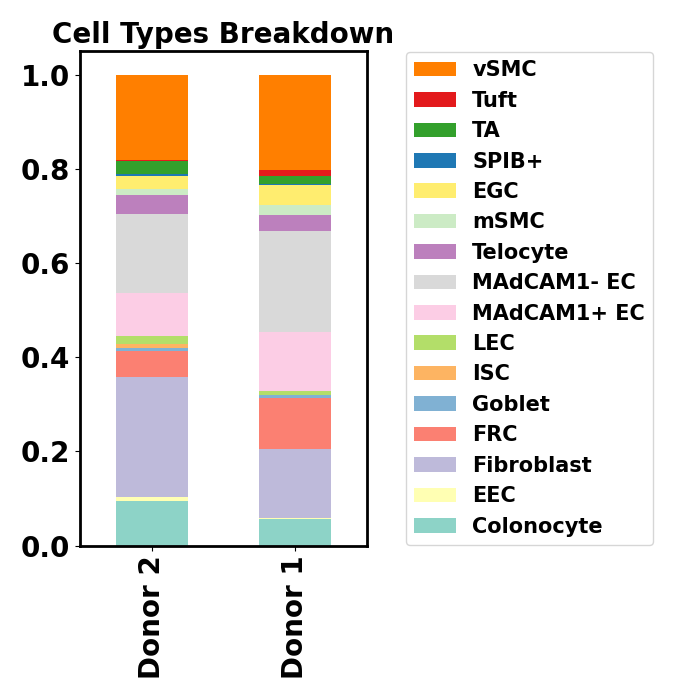

In [103]:
plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})

expand_subtype = pd.DataFrame()
for i in set(adata_nonimmune.obs['Donor ID']):
    pdtemp = pd.DataFrame(adata_nonimmune[adata_nonimmune.obs['Donor ID'] == i,:].obs['celltype_highres_short'].value_counts(normalize = True))
    pdtemp = pdtemp.rename({'proportion': i }, axis='columns')
    expand_subtype = pd.concat([expand_subtype, pdtemp], ignore_index=False, axis=1)
expand_subtype = expand_subtype.reindex(index =adata_nonimmune.obs['celltype_highres_short'].values.categories)
expand_subtype.transpose().plot.bar(stacked=True,color = adata_nonimmune.uns['celltype_highres_short_colors'],fontsize = 20 ).legend(loc='center left',bbox_to_anchor=(1.1, 0.5),fontsize = 15, reverse=True)
plt.title(label = 'Cell Types Breakdown', fontsize = 20,fontweight = 'bold')
plt.tight_layout()
plt.savefig('vis/gut_nonimmune_celltype_breakdown.png',dpi = 300)

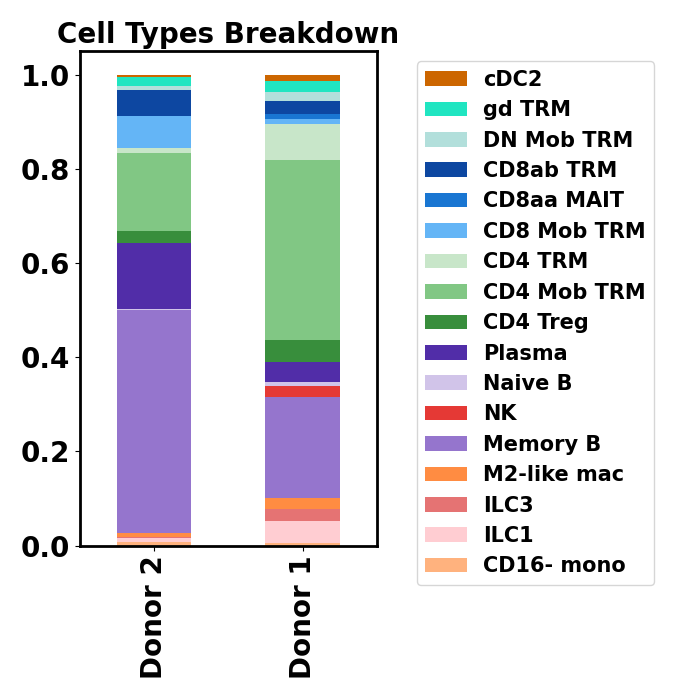

In [102]:
plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})

expand_subtype = pd.DataFrame()
for i in set(adata_immune.obs['Donor ID']):
    pdtemp = pd.DataFrame(adata_immune[adata_immune.obs['Donor ID'] == i,:].obs['celltype_highres_short'].value_counts(normalize = True))
    pdtemp = pdtemp.rename({'proportion': i }, axis='columns')
    expand_subtype = pd.concat([expand_subtype, pdtemp], ignore_index=False, axis=1)
expand_subtype = expand_subtype.reindex(index =adata_immune.obs['celltype_highres_short'].values.categories)
expand_subtype.transpose().plot.bar(stacked=True,color = adata_immune.uns['celltype_highres_short_colors'],fontsize = 20 ).legend(loc='center left',bbox_to_anchor=(1.1, 0.45),fontsize = 15, reverse=True)
plt.title(label = 'Cell Types Breakdown', fontsize = 20,fontweight = 'bold')
plt.tight_layout()
plt.savefig('vis/gut_immune_celltype_breakdown.png',dpi = 300)

In [ ]:
# os.chdir(r'E:\AAA_Labwork\Tcell tissues\v2')
# adata.write('gut_annotated.h5ad')

In [105]:
adata_nonimmune.obs['celltype_highres_short'].values.categories

Index(['Colonocyte', 'EEC', 'Fibroblast', 'FRC', 'Goblet', 'ISC', 'LEC',
       'MAdCAM1+ EC', 'MAdCAM1- EC', 'Telocyte', 'mSMC', 'EGC', 'SPIB+', 'TA',
       'Tuft', 'vSMC'],
      dtype='object')

In [106]:
adata_nonimmune.obs['celltype_highres_short'] = adata_nonimmune.obs['celltype_highres_short'].astype('category')
ordered_celltype=[ 'ISC','TA','Colonocyte', 'SPIB+','Goblet', 'EEC', 'Tuft', 'LEC',
       'MAdCAM1+ EC', 'MAdCAM1- EC', 'Telocyte','Fibroblast', 'FRC',  'mSMC','vSMC', 'EGC']
adata_nonimmune.obs['celltype_highres_short'] = adata_nonimmune.obs['celltype_highres_short'].cat.reorder_categories(ordered_celltype)

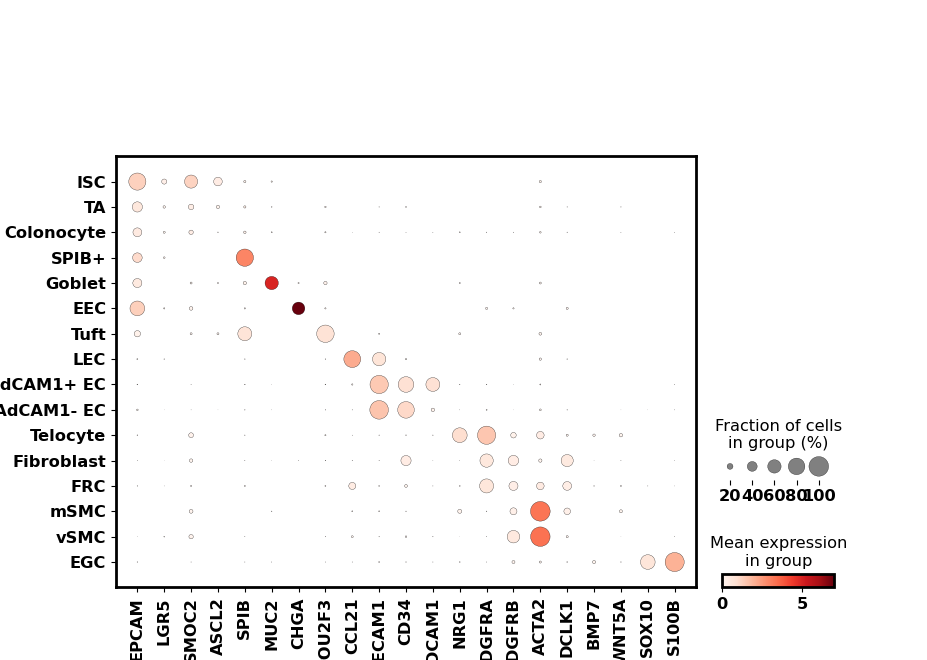

In [ ]:
sc.pl.dotplot(adata_nonimmune, var_names=['EPCAM','LGR5','SMOC2','ASCL2','SPIB','MUC2','CHGA','POU2F3','CCL21',
                                          'PECAM1','CD34','MADCAM1','NRG1','PDGFRA','PDGFRB','ACTA2','DCLK1','BMP7','WNT5A',
                                          'SOX10','S100B'],groupby= 'celltype_highres_short')

In [153]:
gene_list = ['EPCAM','LGR5','SMOC2','ASCL2','SLC26A2','SPIB','MUC2','CHGA','POU2F3','CCL21',
                                          'PECAM1','CD34','MADCAM1','NRG1','PDGFRA','PDGFRB','ACTA2','DCLK1','BMP7','WNT5A',
                                          'SOX10','S100B']
df1 = adata_nonimmune[:,gene_list].to_df()
df1['celltype_highres_short'] = adata_nonimmune.obs['celltype_highres_short']
expression_matrix = df1.groupby('celltype_highres_short').mean()

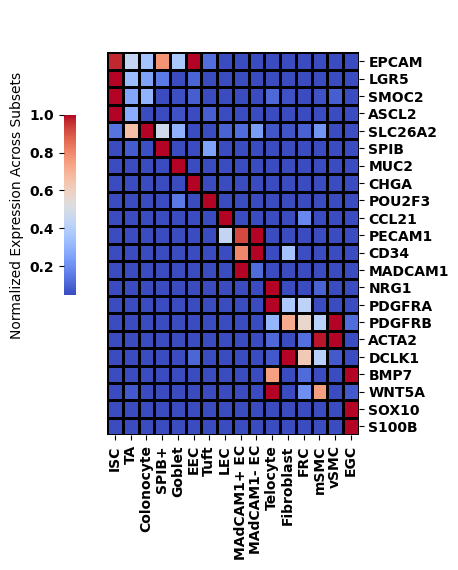

In [154]:
%matplotlib inline
plt.rcParams.update({'font.size': 10, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[8,8]})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': 'coolwarm'}
clustergrid = sns.clustermap(expression_matrix.T,figsize = (4,6),linewidths=2,standard_scale=0,
               linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5,vmax = 1,vmin = 0.05,
               row_cluster = False,col_cluster = False,cbar_kws={'label': 'Normalized Expression Across Subsets','location':"left"},
               **kwargs)
for a in clustergrid.ax_col_dendrogram.collections:
        a.set_linewidth(2)
clustergrid.ax_cbar.set_position([0, 0.5, 0.03, 0.3])

axs = clustergrid.fig.get_axes()
for j in range(0,len(axs)): 
    axs[j].set_xlabel('')

plt.savefig('vis/gut_nonimmune_heatmap.png',dpi = 300,bbox_inches='tight')

In [133]:
adata_immune.obs['celltype_highres_short'].values.categories

Index(['CD16- mono', 'ILC1', 'ILC3', 'M2-like mac', 'Memory B', 'NK',
       'Naive B', 'Plasma', 'CD4 Treg', 'CD4 Mob TRM', 'CD4 TRM',
       'CD8 Mob TRM', 'CD8aa MAIT', 'CD8ab TRM', 'DN Mob TRM', 'gd TRM',
       'cDC2'],
      dtype='object')

In [145]:
adata_immune.obs['celltype_highres_short'] = adata_immune.obs['celltype_highres_short'].astype('category')
ordered_celltype=['DN Mob TRM', 'CD4 Mob TRM', 'CD4 TRM','CD4 Treg','CD8 Mob TRM','CD8ab TRM','CD8aa MAIT',  'gd TRM',
     'ILC1', 'ILC3','NK','Naive B','Memory B', 'Plasma','CD16- mono',  'M2-like mac','cDC2']
adata_immune.obs['celltype_highres_short'] = adata_immune.obs['celltype_highres_short'].cat.reorder_categories(ordered_celltype)

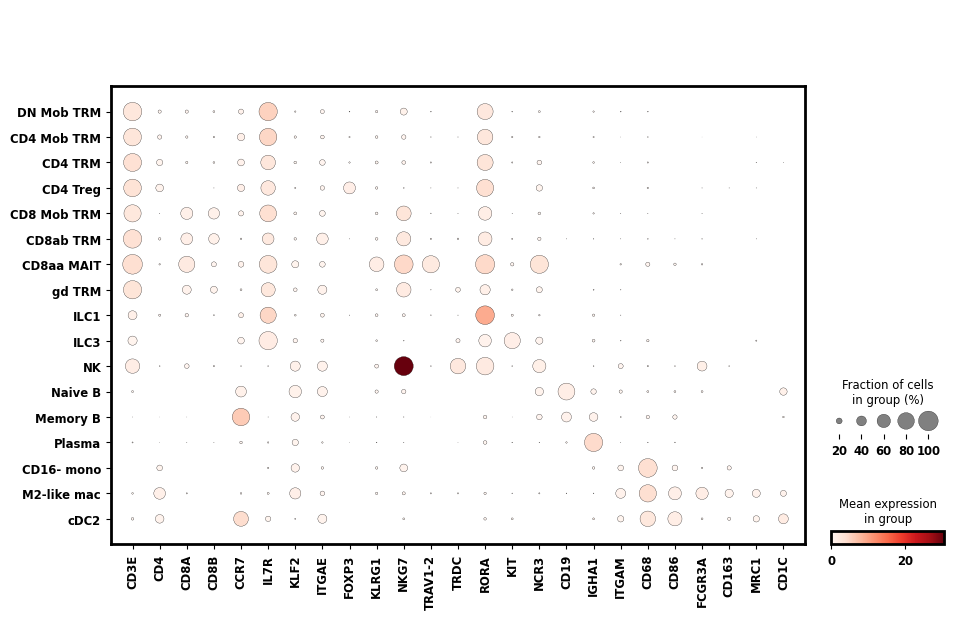

In [146]:
sc.pl.dotplot(adata_immune, var_names=['CD3E','CD4','CD8A','CD8B','CCR7','IL7R','KLF2',
                                   'ITGAE','FOXP3','KLRG1','NKG7','TRAV1-2','TRDC',
                                   'RORA','KIT','NCR3','CD19','IGHA1','ITGAM','CD68','CD86','FCGR3A','CD163','MRC1','CD1C'],groupby= 'celltype_highres_short')

In [147]:
gene_list = ['CD3E','CD4','CD8A','CD8B','CCR7','IL7R','KLF2',
                                   'ITGAE','FOXP3','KLRG1','NKG7','TRAV1-2','TRDC',
                                   'RORA','KIT','NCR3','CD19','IGHA1','ITGAM','CD68','CD86','FCGR3A','CD163','MRC1','CD1C']
df1 = adata_immune[:,gene_list].to_df()
df1['celltype_highres_short'] = adata_immune.obs['celltype_highres_short']
expression_matrix = df1.groupby('celltype_highres_short').mean()

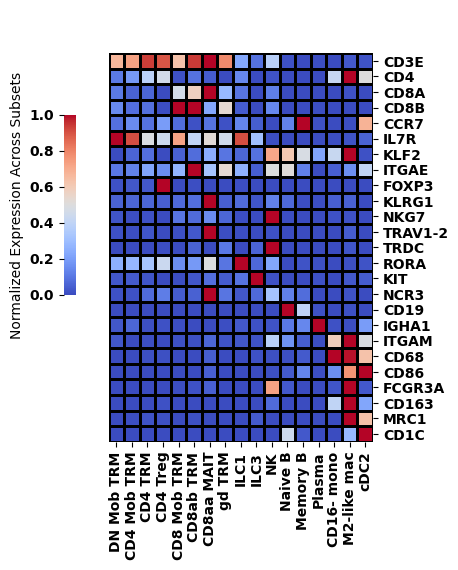

In [150]:
%matplotlib inline
plt.rcParams.update({'font.size': 10, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[8,8]})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': 'coolwarm'}
clustergrid = sns.clustermap(expression_matrix.T,figsize = (4,6),linewidths=2,standard_scale=0,
               linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5,vmax = 1,vmin = 0,
               row_cluster = False,col_cluster = False,cbar_kws={'label': 'Normalized Expression Across Subsets','location':"left"},
               **kwargs)
for a in clustergrid.ax_col_dendrogram.collections:
        a.set_linewidth(2)
clustergrid.ax_cbar.set_position([0, 0.5, 0.03, 0.3])

axs = clustergrid.fig.get_axes()
for j in range(0,len(axs)): 
    axs[j].set_xlabel('')

plt.savefig('vis/gut_immune_heatmap.png',dpi = 300,bbox_inches='tight')

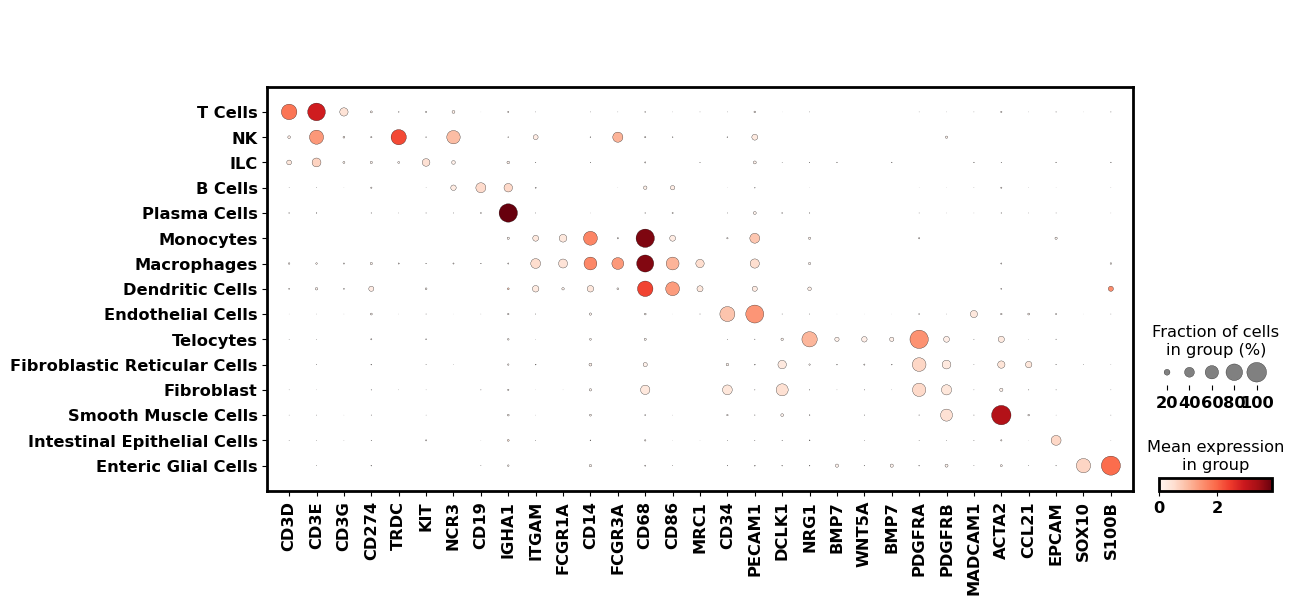

In [ ]:
sc.pl.dotplot(adata, var_names=['CD3D','CD3E','CD3G','CD274','TRDC','KIT','NCR3','CD19','IGHA1','ITGAM','FCGR1A','CD14','FCGR3A','CD68','CD86','MRC1',
                                'CD34','PECAM1','DCLK1','NRG1','BMP7','WNT5A','PDGFRA','PDGFRB','MADCAM1','ACTA2','CCL21','EPCAM','SOX10','S100B'],groupby= 'celltype_lowres')

In [ ]:
gene_list = ['CD3D','CD3E','CD3G','CD274','TRDC','KIT','NCR3','CD19','IGHA1','ITGAM','FCGR1A','CD14','FCGR3A','CD68','CD86','MRC1',
                                'CD34','PECAM1','DCLK1','NRG1','BMP7','WNT5A','PDGFRA','PDGFRB','MADCAM1','ACTA2','CCL21','EPCAM','SOX10','S100B']
df1 = adata[:,gene_list].to_df()
df1['celltype_lowres'] = adata.obs['celltype_lowres']
expression_matrix = df1.groupby('celltype_lowres').mean()

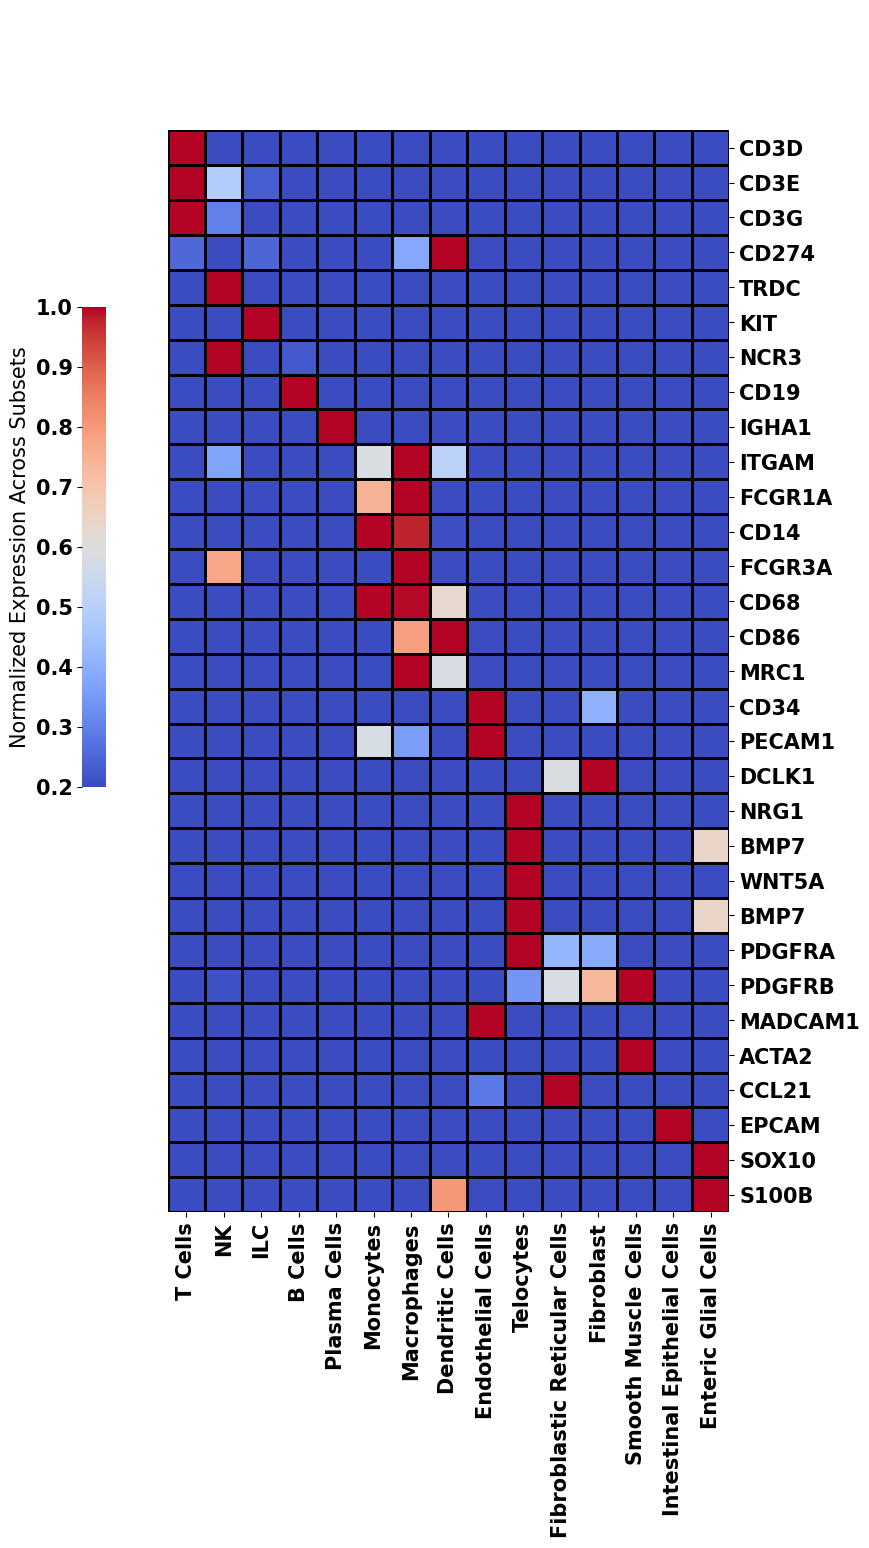

In [42]:
%matplotlib inline
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[8,8]})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': 'coolwarm'}
clustergrid = sns.clustermap(expression_matrix.T,figsize = (8,16),linewidths=2,standard_scale=0,
               linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5,vmax = 1,vmin = 0.2,
               row_cluster = False,col_cluster = False,cbar_kws={'label': 'Normalized Expression Across Subsets','location':"left"},
               **kwargs)
for a in clustergrid.ax_col_dendrogram.collections:
        a.set_linewidth(2)
clustergrid.ax_cbar.set_position([0, 0.5, 0.03, 0.3])

axs = clustergrid.fig.get_axes()
for j in range(0,len(axs)): 
    axs[j].set_xlabel('')

plt.savefig('vis/gut_heatmap.png',dpi = 300,bbox_inches='tight')